In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:30:10_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


In [8]:
!nvidia-smi

Wed Apr 10 12:05:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.78                 Driver Version: 551.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 35%   39C    P8             14W /  170W |    1346MiB /  12288MiB |     22%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load Pollen DETR from Hugging Face Hub

In [15]:
import torch
import supervision as sv
import transformers
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor, pipeline
import re
import os
import glob
import random
import cv2
import numpy as np
import json
import pandas as pd
import shutil
import os
import torchvision
from torch.utils.data import DataLoader

# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'Charliesgt/pollen_detr_resnet50'
CONFIDENCE_TRESHOLD = 0.3
IOU_TRESHOLD = 0.5
INFERENCE_DIRECTORY='../data/raw/ku_pollen/DRB_400x/images/'
pipeline_model = pipeline("object-detection", model=CHECKPOINT, device_map="auto")
#image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
#model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
#model.to(DEVICE)

To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development


## Load Inference Data

In [43]:

# inference
annotations = []
image_urls = [img for img in glob.glob(f'{INFERENCE_DIRECTORY}/*.jpg') if "Carya ovata" in img]

results = pipeline_model(image_urls, threshold=CONFIDENCE_TRESHOLD)


In [44]:
annotations = []
for image_url, bboxes in zip(image_urls, results):
    image_name = image_url.replace('images\\','').split('/')[-1]
    for bbox in bboxes:
        annotations.append({
            'image_name':image_name,
            'x1': bbox['box']['xmin'],
            'y1': bbox['box']['ymin'],
            'x2': bbox['box']['xmax'],
            'y2': bbox['box']['ymax'],
            'class_name':bbox['label'],
            'score':bbox['score'],
            
        })

annotations_df = pd.DataFrame(annotations)

In [21]:
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
detections

TypeError: list indices must be integers or slices, not str

In [74]:

image = cv2.imread('../data/raw/ku_pollen/Images/2020-02-06 100x scan B.jpg')
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=0.2, 
        target_sizes=target_sizes
    )[0]

results

{'scores': tensor([]),
 'labels': tensor([], dtype=torch.int64),
 'boxes': tensor([], size=(0, 4))}

In [ ]:
# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
labels = [
        dataset_detections.classes[class_id]
        for class_id
        in detections.class_id]
frame = box_annotator.annotate(scene=image.copy(), detections=detections)

label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK, text_scale=0.4, text_thickness=1, text_padding=5)
frame = label_annotator.annotate(scene=frame.copy(), detections=detections, labels=[categories[i]['name'] for i in detections.class_id])

print('detections')
%matplotlib inline  
sv.plot_image(frame, (16, 16))

In [ ]:
### FOR TEST DATA

class PollenDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = image_directory_path + '.json'
        super(PollenDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(PollenDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]
        return pixel_values, target
    
def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible 
    # to directly batch together images. Hence they pad the images to the biggest 
    # resolution in a given batch, and create a corresponding binary pixel_mask 
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

test_dataset = PollenDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True
)

## Visualize data entry

**NOTE:** Feel free to reload this cell multiple times. Notebook should display different train set image each time.

In [12]:
dataset_detections = sv.DetectionDataset.from_coco(
    images_directory_path=f"{TRAIN_DATASET.root}",
    annotations_path=f"{TRAIN_DATASET.root}.json",
)

Image #292


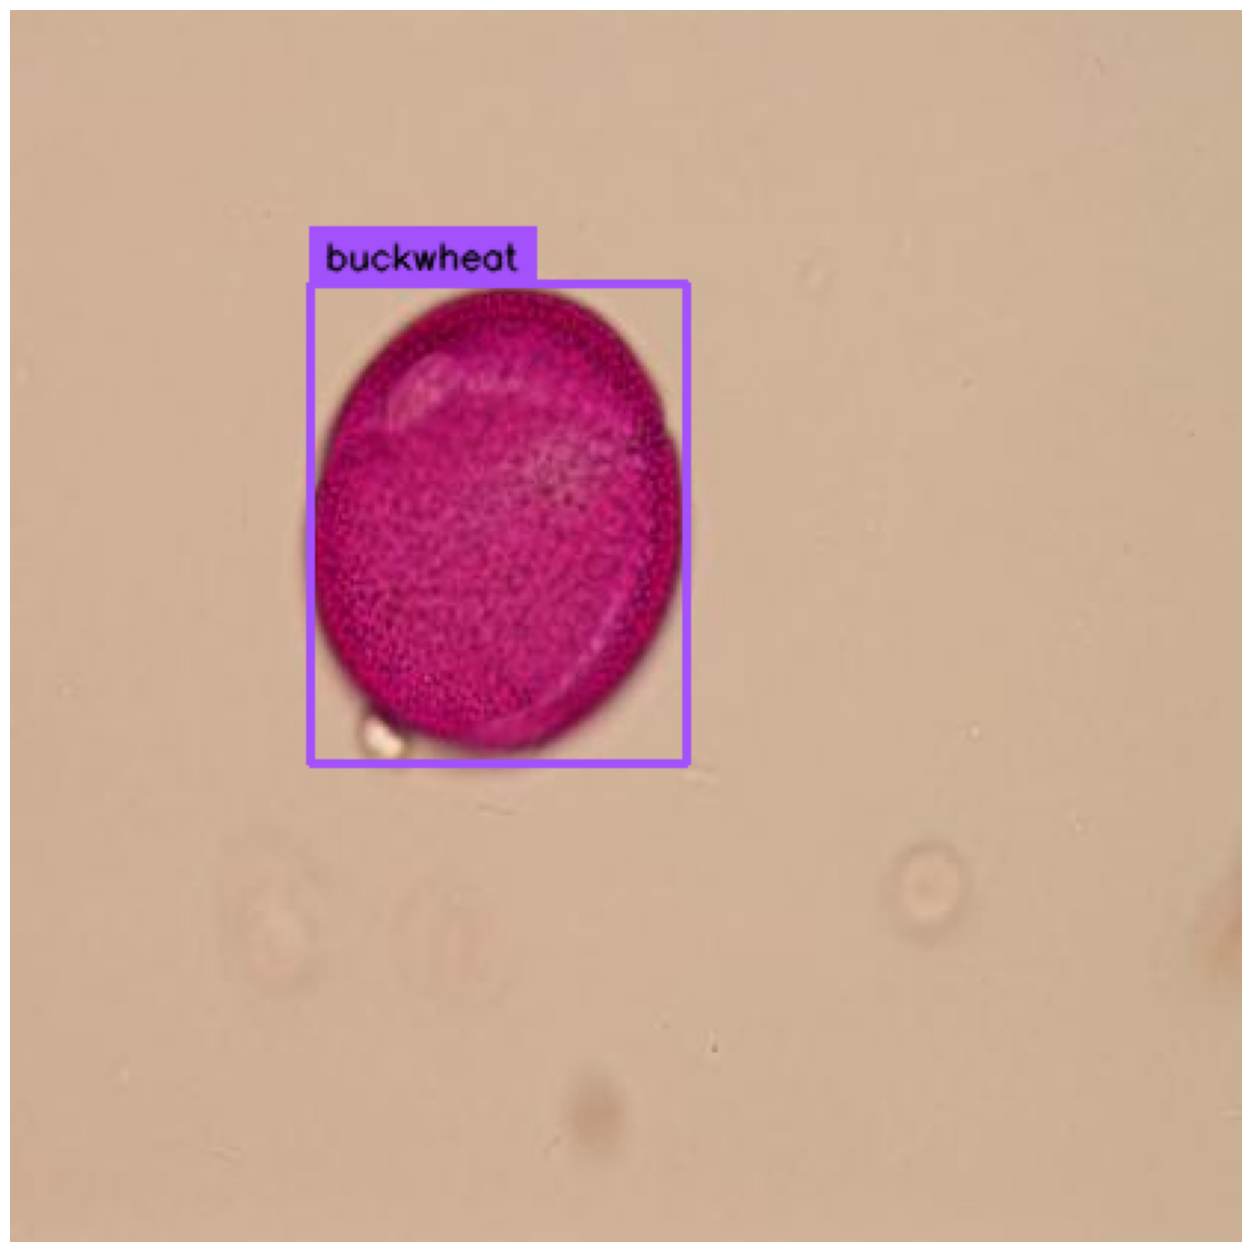

In [13]:
import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
img = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]

image = cv2.imread(TRAIN_DATASET.root+'/'+img['file_name'])

# annotate

detections = dataset_detections.annotations[TRAIN_DIRECTORY+'\\'+img['file_name']]


# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

box_annotator = sv.BoundingBoxAnnotator(thickness=2)
frame = box_annotator.annotate(scene=image.copy(), detections=detections)

label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK, text_scale=0.4, text_thickness=1, text_padding=5)
frame = label_annotator.annotate(scene=frame.copy(), detections=detections, labels=[categories[i]['name'] for i in detections.class_id])

%matplotlib inline  
sv.plot_image(frame, (16, 16))

In [14]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible 
    # to directly batch together images. Hence they pad the images to the biggest 
    # resolution in a given batch, and create a corresponding binary pixel_mask 
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

In [5]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
image_processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = '../data/artifacts/detr-resnet50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

#image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [28]:
import random
import cv2
import numpy as np
dataset_detections = sv.DetectionDataset.from_coco(
    images_directory_path=f"{TEST_DATASET.root}",
    annotations_path=f"{TEST_DATASET.root}.json",
)

# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
img = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image = cv2.imread(TEST_DATASET.root+'/'+img['file_name'])

detections = dataset_detections.annotations[TEST_DIRECTORY+'\\'+img['file_name']]

box_annotator = sv.BoundingBoxAnnotator(thickness=2)
frame = box_annotator.annotate(scene=image.copy(), detections=detections)

label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK, text_scale=0.4, text_thickness=1, text_padding=5)
frame = label_annotator.annotate(scene=frame.copy(), detections=detections, labels=[categories[i]['name'] for i in detections.class_id])

print('ground truth')
%matplotlib inline  
#sv.plot_image(frame, (16, 16))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
labels = [
        dataset_detections.classes[class_id]
        for class_id
        in detections.class_id]
frame = box_annotator.annotate(scene=image.copy(), detections=detections)

label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK, text_scale=0.4, text_thickness=1, text_padding=5)
frame = label_annotator.annotate(scene=frame.copy(), detections=detections, labels=[categories[i]['name'] for i in detections.class_id])

print('detections')
%matplotlib inline  
#sv.plot_image(frame, (16, 16))

SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


Image #155
ground truth
detections


../data/raw/ku_pollen/DRB_400x/images\400x English plantain (Plantango lanceolata)Photo on 7-20-17 at 2.58 PM.jpg
detections


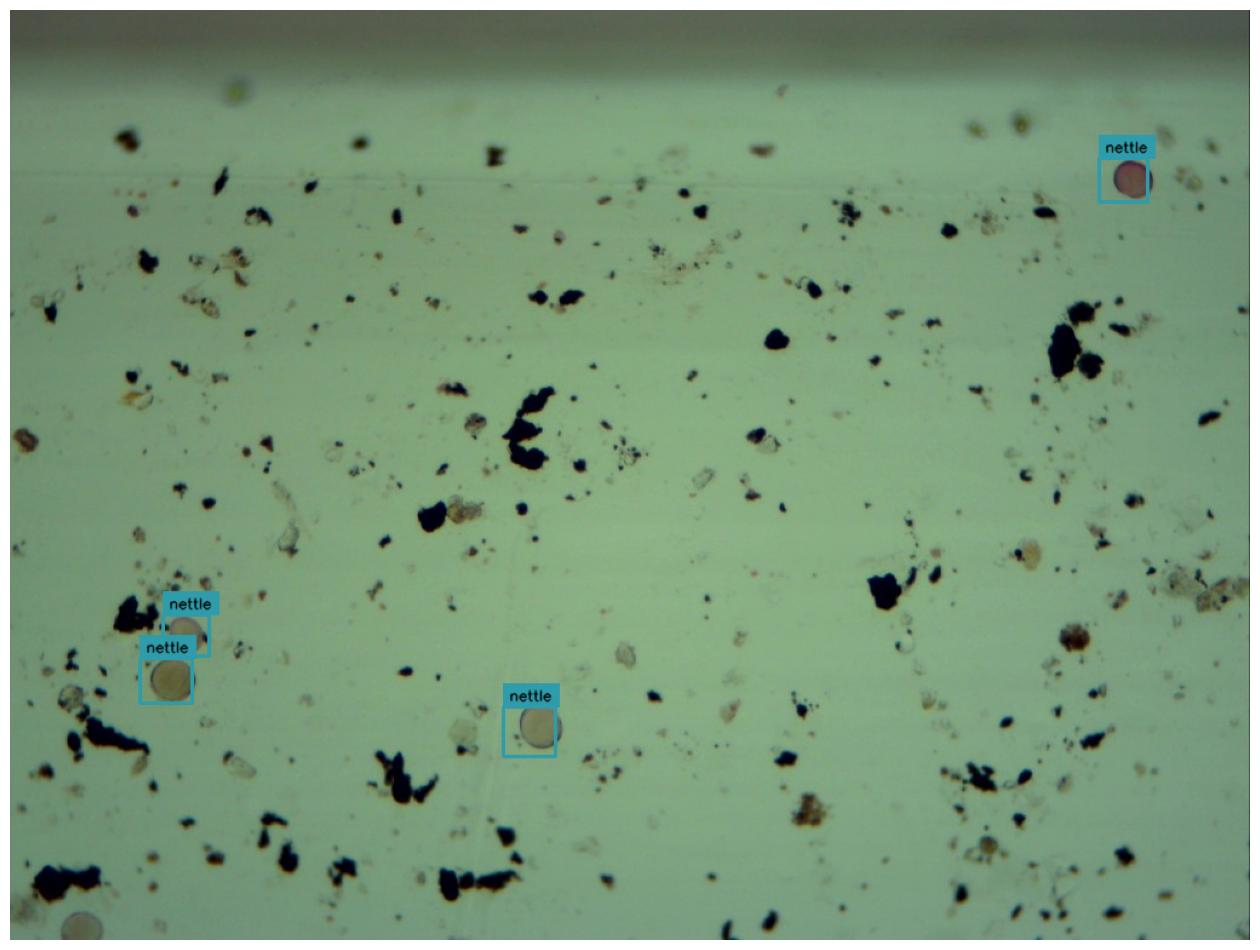

In [55]:
# inference
import glob

image_id = random.choice(glob.glob('../data/raw/ku_pollen/DRB_400x/images/*.jpg'))
print(image_id)
image = cv2.imread('../data/raw/ku_pollen/Images/2020-02-06 100x scan B.jpg')
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=0.2, 
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
labels = [
        dataset_detections.classes[class_id]
        for class_id
        in detections.class_id]
frame = box_annotator.annotate(scene=image.copy(), detections=detections)

label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK, text_scale=0.4, text_thickness=1, text_padding=5)
frame = label_annotator.annotate(scene=frame.copy(), detections=detections, labels=[categories[i]['name'] for i in detections.class_id])

print('detections')
%matplotlib inline  
sv.plot_image(frame, (16, 16))

In [35]:
results

[{'scores': tensor([0.7566]),
  'labels': tensor([0]),
  'boxes': tensor([[ 677.8117,  292.9349, 1176.0610,  737.4734]])}]

In [30]:
detections

Detections(xyxy=array([[1285.3315 ,  697.77924, 1675.1802 , 1086.3071 ]], dtype=float32), mask=None, confidence=array([0.60908544], dtype=float32), class_id=array([0]), tracker_id=None, data={})

## Evaluation on test dataset

Finally, we evaluate the model on the `TEST_DATASET`. For this we make use of the `CocoEvaluator` class available in a tiny [PyPi package](https://github.com/NielsRogge/coco-eval) made by [Niels Rogge](https://github.com/NielsRogge) . This class is entirely based on the [original evaluator](https://github.com/facebookresearch/detr/blob/main/datasets/coco_eval.py) class used by the DETR authors.

In [ ]:
!pip install -q coco_eval

  Preparing metadata (setup.py) ... done


In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [59]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

ModuleNotFoundError: No module named 'coco_eval'

## Save and load model

In [60]:
DetrForObjectDetection.from_pretrained('charliesgt/pollen_detr')

To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections...
